In [1]:
#3.4 EWO Revision 3
#EWO = Elliott Wave Oscillator
#The current code only focuses on the long position

import pandas_datareader as pdr
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import dataframe_image as dfi
import seaborn as sns
from pylab import *

#lobf(x) function returns the slope of the line of best fit using OLS with input of pandas series
def lobf(x):
    line_fitter = LinearRegression()
    line_fitter.fit(np.array(x.index).reshape(-1 , 1), x.values)
    return line_fitter.coef_

In [2]:
target_market = 'SPY'
start_date = '2010-06-28'
end_date = '2019-06-28'

#Import and initialize SPY dataframe
sp500 = pdr.get_data_yahoo(target_market, start_date, end_date)
day = np.arange(1, len(sp500) + 1)
sp500['Day'] = day 
sp500['2-day'] = sp500['Close'].rolling(2).mean()   #Column for 2-day SMA
sp500['45-day'] = sp500['Close'].rolling(45).mean() #Column for 45-day SMA
sp500['50-day'] = sp500['Close'].rolling(50).mean() #Column for 50-day SMA
sp500['EWO'] = sp500['2-day'] - sp500['45-day']     #Column for EWO
sp500 = sp500[['Day', 'Open', 'Close', '2-day', '45-day', '50-day', 'EWO']]
sp500 = sp500.reset_index()
sp500 = sp500.set_index('Day')

#Check whether EWO of each day is over a certain positive value, which is 1% of 2-day SMA
#(value 1 = Yes, value 0 = No)
sp500['Filter1'] = np.where(sp500['EWO'] > sp500['2-day']/100, 1, 0)

#Check whether the slope of the line of best fit corresponding to five most recent EWO values is positive
#(value 1 = Yes, value 0 = No)
sp500['Filter2'] = np.where(sp500['EWO'].rolling(5).apply(lobf) > 0, 1, 0)

#Check whether the current price is in uptrend (i.e. Closing Price > 50-day SMA)
#(value 1 = Yes, value 0 = No)
sp500['Filter3'] = np.where(sp500['Close'] > sp500['50-day'], 1, 0)

#Check whether there's a notable drop in the market
#(value 1 = Yes, value 0 = No)
sp500['Filter4'] = np.where(sp500['EWO'] < -sp500['2-day']*10/100, 1, 0)

sp500.dropna(inplace=True)

#Indicate where the 5-day EWO's slope is negative AND where the price is in downtrend
#(value -1 = Yes, value 0 = No)
sp500['Exit1'] = np.where(sp500['EWO'].rolling(5).apply(lobf) < 0, -1, 0)
sp500['Exit2'] = np.where(sp500['Close'].rolling(125).apply(lobf) < 0, -1, 0)

#sp500_buy dataframe refers to the buy signals, where either all of conditions 1, 2, and 3 are satisfied
#or condition 4 is satisfied
condition1 = (sp500['Filter1'] == 1)
condition2 = (sp500['Filter2'] == 1)
condition3 = (sp500['Filter3'] == 1)
condition4 = (sp500['Filter4'] == 1)
sp500_buy = sp500.loc[condition1&condition2&condition3|condition4]

In [3]:
#Backtesting of initial strategy on SPY from start_date to end_date
budget = 100000 #Initial Budget = 100,000 USD
buy_list = []   #List storing all the buy signals
sell_list = []  #List storing all the sell signals
sold_day = 0
bought_amount = 0
trade_num = 0

#This varaible tells whether the trade started from condition 4 is ongoing
#(value 1 = Yes, value 0 = No)
exc = 0

for i in range(len(list(sp500_buy.index))-1): #Iterate the elements in sp500_buy, which contains buy signals
    #If there are consecutive buy signals w/o a sell signal, continue the first buy signal
    if (sold_day > list(sp500_buy.index)[i]+1) or \
    (sp500_buy.loc[list(sp500_buy.index)[i], 'Filter4'] == 1) and (exc == 1): 
        continue
    if bought_amount == 0: #Enter a trade only when there is no current position
        #Buy the security at the next morning's open price
        bought_day = list(sp500_buy.index)[i]+1
        buy_list.append(bought_day)
        bought_price = sp500.loc[bought_day, 'Open']
        bought_amount = budget // bought_price #Buy as many security as the budget allows at that price
        budget -= bought_amount * bought_price #Remaining budget after having a long position
        #print(int(bought_amount), "amount of SPY security is bought at", \
              #bought_price, "on", sp500.loc[bought_day, "Date"], "(Day", bought_day, ")")
        #print(budget, "is the remaining budget")
        
        if sp500.loc[bought_day-1, 'Filter4'] == 1:
            exc = 1 #The trade started from condition 4 begins
            continue
            
    if sp500_buy.loc[list(sp500_buy.index)[i], 'Filter4'] == 0:
        bought_day = list(sp500_buy.index)[i]+1
        
    #Beginning from the day of long position until the end_date,
    #check whether both exit signals are satisfied simultaneously or whether it is the last day of trading
    for j in range(bought_day, sp500.iloc[[-1]].index[0]):
        if (sp500.loc[j, 'Exit1'] == -1) and (sp500.loc[j, 'Exit2'] == -1) or \
        (j == sp500.iloc[[-1]].index[0]-1):
            #Sell the security at the next morning's open price
            sold_day = j+1
            sold_price = sp500.loc[sold_day, 'Open']
            sell_list.append(sold_day)
            budget += bought_amount * sold_price
            #print(int(bought_amount), 'amount of SPY security is sold at',
                  #sold_price, 'on', sp500.loc[sold_day, "Date"], "(Day", sold_day, ")")
            #print("After closing the position, current budget is", budget)
            #print("\n")
            #Reset the parameters
            bought_amount = 0
            exc = 0
            trade_num += 1
            break
            
if bought_amount != 0: #In case the position is not cleared after the end_date
    sold_day = sp500.iloc[[-1]].index[0]
    sold_price = sp500.loc[sold_day, 'Open']
    sell_list.append(sold_day)
    budget += bought_amount * sold_price
    #print(int(bought_amount), 'amount of SPY security is sold at', \
        #sold_price, 'on', sp500.loc[sold_day, "Date"], "(Day", sold_day, ")")
    #print("After closing the position, current budget is", budget)
    #print("\n")
    #Reset the parameter
    bought_amount = 0
    exc = 0
    trade_num += 1

#print("The final budget of EWO strategy is", round(budget), "USD")
#print("Total number of trades is", trade_num)

#All buy signals after the trade
sp500_buy = sp500.copy()
sp500_buy = sp500_buy.loc[buy_list] 

#All sell signals after the trade
sp500_sell = sp500.copy()
sp500_sell = sp500_sell.loc[sell_list]

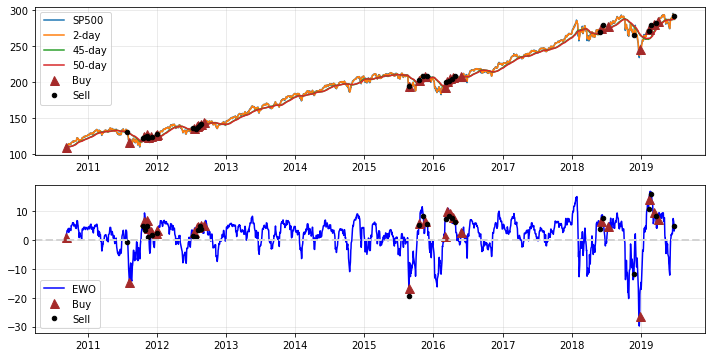

In [4]:
#Visualize the price trend, EWO value, buy signals, and sell signals throughout the trading
plt.rcParams['figure.figsize'] = 12, 6
 
plt.subplot(211) #Upper plot
plt.grid(True, alpha = .3)
plt.plot(sp500['Date'], sp500['Close'], label = 'SP500')   #SP500
plt.plot(sp500['Date'], sp500['2-day'], label = '2-day')   #2-day SMA
plt.plot(sp500['Date'], sp500['45-day'], label = '45-day') #45-day SMA
plt.plot(sp500['Date'], sp500['50-day'], label = '50-day') #50-day SMA
plt.plot(sp500_buy['Date'], sp500_buy['Close'], '^',
         color = 'brown', label='Buy', markersize = 9) #Buy signals
plt.plot(sp500_sell['Date'], sp500_sell['Open'], '.',
         color = 'k', label='Sell', markersize = 9)    #Sell signals
plt.legend(loc='upper left')

plt.subplot(212) #Lower plot for EWO 
plt.grid(True, alpha = .3)
plt.plot(sp500['Date'], sp500['EWO'], color='blue', label = 'EWO') #EWO
plt.plot(sp500_buy['Date'], sp500_buy['EWO'], '^',
         color = 'brown', label='Buy', markersize = 9) #Buy signals
plt.plot(sp500_sell['Date'], sp500_sell['EWO'], '.',
         color = 'k', label='Sell', markersize = 9)    #Sell signals
plt.axhline(0, color='lightgray', linestyle='--', linewidth=2) #x-axis
plt.legend(loc='lower left')
plt.show()